# Homeowner Loss History Prediction

## 1. Library Downloads

In [1]:

%%capture

!pip install --upgrade pip
!pip install -q numpy pandas scikit-learn xgboost matplotlib seaborn scipy shap statsmodels
!pip install imbalanced-learn
!pip install --upgrade xgboost
!pip install mlflow joblib boto3 s3fs

## 2. Imports

In [2]:
# Step 2: Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from scipy.stats import skew
import warnings
import mlflow
import mlflow.xgboost
import joblib
import boto3
warnings.filterwarnings('ignore')


## 3. Load the Dataset and Initial Inspection

In [3]:
import s3fs  # pip install s3fs if needed

# S3 path to your dataset
s3_uri = "s3://grange-seniordesign-bucket/raw-data/ut_loss_history_1.csv"

# Step 1: Load the dataset from S3
try:
    data = pd.read_csv(s3_uri)
    print("Data imported successfully from:", s3_uri)
except FileNotFoundError:
    print("Dataset not found. Please check the S3 path and IAM permissions.")
    import sys
    sys.exit()
except Exception as e:
    print("Error reading from S3:", e)
    import sys
    sys.exit()

# Step 2: Initial inspection
print("Shape of the dataset:", data.shape)
print("Columns in the dataset:", data.columns.tolist())
data.info()
display(data.head())

# Step 3: Statistical summary
print("\nStatistical summary of numerical features:")
display(data.describe())


Data imported successfully from: s3://grange-seniordesign-bucket/raw-data/ut_loss_history_1.csv
Shape of the dataset: (1633733, 109)
Columns in the dataset: ['rowid', 'mod', 'eey', 'cc_total', 'il_total', 'num_loss_3yr_fire', 'num_loss_yrs45_fire', 'loss_free_yrs_fire', 'num_loss_3yr_windhail', 'num_loss_yrs45_windhail', 'loss_free_yrs_windhail', 'num_loss_3yr_windhail_sm', 'num_loss_yrs45_windhail_sm', 'loss_free_yrs_windhail_sm', 'num_loss_3yr_windhail_lg', 'num_loss_yrs45_windhail_lg', 'loss_free_yrs_windhail_lg', 'num_loss_3yr_water', 'num_loss_yrs45_water', 'loss_free_yrs_water', 'num_loss_3yr_water_wthr', 'num_loss_yrs45_water_wthr', 'loss_free_yrs_water_wthr', 'num_loss_3yr_water_othr', 'num_loss_yrs45_water_othr', 'loss_free_yrs_water_othr', 'num_loss_3yr_lightning', 'num_loss_yrs45_lightning', 'loss_free_yrs_lightning', 'num_loss_3yr_theft', 'num_loss_yrs45_theft', 'loss_free_yrs_theft', 'num_loss_3yr_other_w_snow', 'num_loss_yrs45_other_w_snow', 'loss_free_yrs_other_w_snow', 

,rowid,mod,eey,cc_total,il_total,num_loss_3yr_fire,num_loss_yrs45_fire,loss_free_yrs_fire,num_loss_3yr_windhail,num_loss_yrs45_windhail,...,lhdwc_5y_4d_water_nw,lhdwc_5y_4d_water_w,lhdwc_5y_4d_theft,lhdwc_5y_4d_other,lhdwc_5y_4d_sewer,lhdwc_5y_4d_weather,lhdwc_5y_4d_nonweather,lhdwc_5y_4d_small,lhdwc_5y_4d_large,lhdwc_5y_4d_total
0,1000001,0,1.00,0,0.0,0,0,5,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1000002,1,0.33,0,0.0,0,0,5,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1000003,5,1.00,0,0.0,0,0,5,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000004,6,1.00,0,0.0,0,0,5,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000005,7,1.00,0,0.0,0,0,5,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Statistical summary of numerical features:


,rowid,mod,eey,cc_total,il_total,num_loss_3yr_fire,num_loss_yrs45_fire,loss_free_yrs_fire,num_loss_3yr_windhail,num_loss_yrs45_windhail,...,lhdwc_5y_4d_water_nw,lhdwc_5y_4d_water_w,lhdwc_5y_4d_theft,lhdwc_5y_4d_other,lhdwc_5y_4d_sewer,lhdwc_5y_4d_weather,lhdwc_5y_4d_nonweather,lhdwc_5y_4d_small,lhdwc_5y_4d_large,lhdwc_5y_4d_total
count,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,...,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06,1.633733e+06
mean,1.816867e+06,6.446012e+00,9.385785e-01,4.699911e-02,6.061592e+02,4.925529e-03,3.576472e-03,4.975243e+00,7.716255e-02,4.583062e-02,...,4.388529e-02,2.905600e-02,1.553106e-02,3.395351e-02,3.227264e-02,1.347067e-01,9.883200e-02,3.325078e-02,1.957974e-01,2.290482e-01
std,4.716182e+05,7.949529e+00,2.627191e-01,2.183055e-01,6.791575e+03,7.038403e-02,6.001360e-02,2.984380e-01,2.785327e-01,2.154382e-01,...,2.044885e-01,1.661056e-01,1.185546e-01,1.841603e-01,1.751518e-01,3.468224e-01,3.137912e-01,1.756920e-01,4.323293e-01,4.728922e-01
min,1.000001e+06,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.408434e+06,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.816867e+06,3.000000e+00,1.068000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.225300e+06,9.000000e+00,1.068000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.633733e+06,7.200000e+01,1.153000e+00,4.000000e+00,1.272760e+06,2.000000e+00,3.000000e+00,5.000000e+00,5.000000e+00,1.100000e+01,...,1.076600e+01,1.076600e+01,9.147000e+00,5.892000e+00,1.076600e+01,1.378400e+01,1.642500e+01,8.157000e+00,1.867600e+01,1.962200e+01


## 4. Create Target and Weight Variables

In [4]:
# Step 4: Create Target and Weight Variables

# Ensure required columns exist
required_columns = ['il_total', 'eey']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    print(f"Missing required columns: {missing_columns}. Please check the dataset.")
    sys.exit()

# Create target variable (Pure Premium)
data['trgt'] = data['il_total'] / data['eey']  # Pure Premium

# Create sample weight variable based on earned exposure years
data['wt'] = data['eey']

## 5. Select Model 4 Features

In [5]:
# Step 5: Select Predictor Columns

# Select columns starting with 'lhdwc_5y_3d_'
model_columns = [col for col in data.columns if col.startswith('lhdwc_5y_2d_')]
if not model_columns:
    print("No columns found with 'lhdwc_5y_2d_' prefix. Exiting.")
    sys.exit()

print("\nSelected Model Columns:")
print(model_columns)

# Step 6: Create 'prior_loss_ind' Variable

# We'll define 'prior_loss_ind' as 1 when there is no prior loss
# Sum up the selected columns; if the sum is zero, there is no prior loss
data['prior_loss_ind'] = (data[model_columns].sum(axis=1) == 0).astype(int)

# Step 7: Prepare Feature Matrix and Target Variable

# Include 'prior_loss_ind' in the features
X = data[model_columns + ['prior_loss_ind']].copy()
y = data['trgt']
w = data['wt']



Selected Model Columns:
['lhdwc_5y_2d_fire', 'lhdwc_5y_2d_wind', 'lhdwc_5y_2d_hail', 'lhdwc_5y_2d_water', 'lhdwc_5y_2d_water_nw', 'lhdwc_5y_2d_water_w', 'lhdwc_5y_2d_theft', 'lhdwc_5y_2d_other', 'lhdwc_5y_2d_sewer', 'lhdwc_5y_2d_weather', 'lhdwc_5y_2d_nonweather', 'lhdwc_5y_2d_small', 'lhdwc_5y_2d_large', 'lhdwc_5y_2d_total']


## 6. Apply Decay Weights to Features

In [6]:
# Step 6: Apply Decay Weights to Features

# Define decay weights for faster-than-linear decay
decay_weights = {'1d': 1.0, '2d': 0.8, '3d': 0.6, '4d': 0.4, '5d': 0.2} #Change for each model

# Apply decay weights
for col in model_columns:
    for suffix, weight in decay_weights.items():
        if suffix in col:
            X[col] *= weight
            break

print("\nDecay weights applied to features.")

# Step 9: Handle Missing Values

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X = X_imputed


Decay weights applied to features.


## 7. Handle Skewness in Features and Target Variables

In [7]:
# Step 7: Handle Skewness in Features and Target

# --- Handling Skewness in Features ---
# Identify skewed features (features with skewness > 0.75 or < -0.75)
skewed_features = X.drop(columns=['prior_loss_ind']).apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_cols = skewed_features[abs(skewed_features) > 0.75].index.tolist()

# Initialize PowerTransformer for features
if skewed_cols:
    print(f"Handling skewness for features: {skewed_cols}")
    feature_transformer = PowerTransformer()
    X[skewed_cols] = feature_transformer.fit_transform(X[skewed_cols])
else:
    print("No skewed features detected. Skipping transformation for features.")

# --- Handling Skewness in Target ---
# Check skewness of the target variable (y)
target_skew = skew(y)
if abs(target_skew) > 1:  # Apply PowerTransformer if skewness is high
    print(f"Handling skewness for target (y) with skewness: {target_skew:.2f}")
    target_transformer = PowerTransformer()
    y_transformed = target_transformer.fit_transform(y.values.reshape(-1, 1)).flatten()
    y = pd.Series(y_transformed, index=y.index)
else:
    print(f"Target (y) skewness is low ({target_skew:.2f}). No transformation applied.")
    target_transformer = None


Handling skewness for features: ['lhdwc_5y_2d_fire', 'lhdwc_5y_2d_theft', 'lhdwc_5y_2d_water_w', 'lhdwc_5y_2d_sewer', 'lhdwc_5y_2d_other', 'lhdwc_5y_2d_hail', 'lhdwc_5y_2d_small', 'lhdwc_5y_2d_water_nw', 'lhdwc_5y_2d_water', 'lhdwc_5y_2d_nonweather', 'lhdwc_5y_2d_wind', 'lhdwc_5y_2d_large', 'lhdwc_5y_2d_total', 'lhdwc_5y_2d_weather']
Handling skewness for target (y) with skewness: 131.09


## 8. Standardize Features

In [8]:
# Step 8: Standardize Features

# Standardize numerical features (exclude 'prior_loss_ind')
numeric_cols = X.columns.drop('prior_loss_ind')
scaler = StandardScaler()
X_scaled_numeric = pd.DataFrame(
    scaler.fit_transform(X[numeric_cols]),
    columns=numeric_cols,
    index=X.index
)

# Combine scaled numerical features with 'prior_loss_ind'
X_scaled = pd.concat([X_scaled_numeric, X['prior_loss_ind']], axis=1)
X = X_scaled

## 9. Split the Train and Test Data

In [9]:
# Step 9: Train-Test Split

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.4, random_state=42, stratify=None)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 980239 samples
Test set size: 653494 samples


## 10. Handle Data Imbalance in Training Data Only

In [10]:
# Step 10: Handle Data Imbalance in Training Data Only

# Check for imbalance in prior_loss_ind
imbalance_summary = X_train['prior_loss_ind'].value_counts()
print("\nImbalance in 'prior_loss_ind' (Training Data):")
print(imbalance_summary)

# Identify majority and minority classes
majority_class = imbalance_summary.idxmax()
minority_class = imbalance_summary.idxmin()

print(f"Majority class: {majority_class}, Minority class: {minority_class}")

X_majority = X_train[X_train['prior_loss_ind'] == majority_class]
y_majority = y_train[X_train['prior_loss_ind'] == majority_class]
w_majority = w_train[X_train['prior_loss_ind'] == majority_class]

X_minority = X_train[X_train['prior_loss_ind'] == minority_class]
y_minority = y_train[X_train['prior_loss_ind'] == minority_class]
w_minority = w_train[X_train['prior_loss_ind'] == minority_class]

# Oversample minority class
if len(X_minority) > 0:
    X_minority_oversampled, y_minority_oversampled, w_minority_oversampled = resample(
        X_minority,
        y_minority,
        w_minority,
        replace=True,
        n_samples=len(X_majority),
        random_state=42
    )

    # Combine majority and oversampled minority class
    X_train_balanced = pd.concat([X_majority, X_minority_oversampled])
    y_train_balanced = pd.concat([y_majority, y_minority_oversampled])
    w_train_balanced = pd.concat([w_majority, w_minority_oversampled])

    print("\nBalanced training data size:", X_train_balanced.shape)
else:
    # If minority class is empty, use the majority class only
    print("Minority class has zero samples. Using majority class only for training.")
    X_train_balanced = X_majority
    y_train_balanced = y_majority
    w_train_balanced = w_majority

print("Balanced X_train shape:", X_train_balanced.shape)
print("Balanced y_train shape:", y_train_balanced.shape)
print("Balanced w_train shape:", w_train_balanced.shape)


Imbalance in 'prior_loss_ind' (Training Data):
prior_loss_ind
1.0    756991
0.0    223248
Name: count, dtype: int64
Majority class: 1.0, Minority class: 0.0

Balanced training data size: (1513982, 15)
Balanced X_train shape: (1513982, 15)
Balanced y_train shape: (1513982,)
Balanced w_train shape: (1513982,)


## 11. Hyperparameter Tuning

In [11]:
%%time
# Step 11: Hyperparameter Tuning with RandomizedSearchCV

# Drop 'prior_loss_ind' from feature names as it is not used for training
feature_names = X_train_balanced.drop(columns=['prior_loss_ind']).columns.tolist()

# After creating `feature_names`, build a list of +1
monotone_list = [1]*len(feature_names)

# Convert to a comma-separated string inside parentheses,
# e.g. "(1,1,1,...)"
monotone_str = "(" + ",".join(str(c) for c in monotone_list) + ")"


# Parameter grid for RandomizedSearchCV
param_grid = [
    {
        'monotone_constraints': [monotone_str],  
        'booster': ['gbtree'],
        'n_estimators': [150, 400, 420],  # Increased to allow more trees
        'max_depth': [8, 10, 12],  # Increased to allow deeper trees
        'learning_rate': [0.01, 0.015],  # Lower learning rate for finer adjustments
        'subsample': [0.7, 0.75, 0.8],  # Slightly reduced to add variability and avoid overfitting
        'colsample_bytree': [0.85, 0.9],  # Similar to subsample to diversify columns per tree
        'reg_alpha': [0.01, 0.05, 0.1, 1.0],  # Lowered to make regularization less strict
        'reg_lambda': [0.005, 0.01],  # Lowered for similar reasons
        'min_child_weight': [1, 2, 3, 4],  # Added for finer control over minimum sum of weights in leaf nodes
        'gamma': [0.2, 0.25]  # Added to control minimum loss reduction required for further partitioning
    }
]

# Initialize XGBRegressor with early stopping
model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
    eval_metric='rmse'         # Specify evaluation metric
)

# Perform RandomizedSearchCV with adjusted sample weights
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=5,                      # Using 5-fold cross-validation
    verbose=2,
    random_state=42,
)

print("\nStarting hyperparameter tuning with RandomizedSearchCV...")
random_search.fit(
    X_train_balanced,
    y_train_balanced,
    sample_weight=w_train_balanced
)

# Retrieve the best model
best_model = random_search.best_estimator_
print("\nBest model parameters:")
print(random_search.best_params_)

print("\nModel training completed.")


Starting hyperparameter tuning with RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.01, max_depth=12, min_child_weight=4, monotone_constraints=(1,1,1,1,1,1,1,1,1,1,1,1,1,1), n_estimators=420, reg_alpha=1.0, reg_lambda=0.005, subsample=0.8; total time=  32.7s
[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.01, max_depth=12, min_child_weight=4, monotone_constraints=(1,1,1,1,1,1,1,1,1,1,1,1,1,1), n_estimators=420, reg_alpha=1.0, reg_lambda=0.005, subsample=0.8; total time=  30.4s
[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.01, max_depth=12, min_child_weight=4, monotone_constraints=(1,1,1,1,1,1,1,1,1,1,1,1,1,1), n_estimators=420, reg_alpha=1.0, reg_lambda=0.005, subsample=0.8; total time=  32.9s
[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.01, max_depth=12, min_child_weight=4, monotone_constra

[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.01, max_depth=12, min_child_weight=3, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdwc_5y_3d_large': 1, 'lhdwc_5y_3d_total': 1}, n_estimators=420, reg_alpha=0.01, reg_lambda=0.005, subsample=0.75; total time=  29.3s
[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.01, max_depth=12, min_child_weight=3, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 

[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.25, learning_rate=0.01, max_depth=12, min_child_weight=2, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdwc_5y_3d_large': 1, 'lhdwc_5y_3d_total': 1}, n_estimators=420, reg_alpha=0.05, reg_lambda=0.01, subsample=0.7; total time=  26.5s
[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.25, learning_rate=0.01, max_depth=12, min_child_weight=2, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 

[CV] END booster=gbtree, colsample_bytree=0.9, gamma=0.25, learning_rate=0.015, max_depth=10, min_child_weight=2, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdwc_5y_3d_large': 1, 'lhdwc_5y_3d_total': 1}, n_estimators=150, reg_alpha=0.1, reg_lambda=0.005, subsample=0.7; total time=  10.3s
[CV] END booster=gbtree, colsample_bytree=0.9, gamma=0.25, learning_rate=0.015, max_depth=10, min_child_weight=2, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 

[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.25, learning_rate=0.015, max_depth=12, min_child_weight=4, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdwc_5y_3d_large': 1, 'lhdwc_5y_3d_total': 1}, n_estimators=150, reg_alpha=0.01, reg_lambda=0.005, subsample=0.75; total time=   9.9s
[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.25, learning_rate=0.015, max_depth=12, min_child_weight=4, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small':

[CV] END booster=gbtree, colsample_bytree=0.9, gamma=0.2, learning_rate=0.015, max_depth=10, min_child_weight=4, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdwc_5y_3d_large': 1, 'lhdwc_5y_3d_total': 1}, n_estimators=150, reg_alpha=1.0, reg_lambda=0.005, subsample=0.75; total time=  10.0s
[CV] END booster=gbtree, colsample_bytree=0.9, gamma=0.2, learning_rate=0.015, max_depth=10, min_child_weight=4, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, '

[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.015, max_depth=8, min_child_weight=4, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdwc_5y_3d_large': 1, 'lhdwc_5y_3d_total': 1}, n_estimators=150, reg_alpha=0.01, reg_lambda=0.005, subsample=0.8; total time=   9.5s
[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.015, max_depth=8, min_child_weight=4, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, '

[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.25, learning_rate=0.015, max_depth=8, min_child_weight=3, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdwc_5y_3d_large': 1, 'lhdwc_5y_3d_total': 1}, n_estimators=150, reg_alpha=0.05, reg_lambda=0.01, subsample=0.8; total time=  10.0s
[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.25, learning_rate=0.015, max_depth=8, min_child_weight=3, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 

[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.01, max_depth=8, min_child_weight=3, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdwc_5y_3d_large': 1, 'lhdwc_5y_3d_total': 1}, n_estimators=400, reg_alpha=1.0, reg_lambda=0.01, subsample=0.7; total time=  24.3s
[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.01, max_depth=8, min_child_weight=3, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdw

[CV] END booster=gbtree, colsample_bytree=0.9, gamma=0.2, learning_rate=0.015, max_depth=10, min_child_weight=1, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdwc_5y_3d_large': 1, 'lhdwc_5y_3d_total': 1}, n_estimators=420, reg_alpha=0.01, reg_lambda=0.005, subsample=0.8; total time=  28.8s
[CV] END booster=gbtree, colsample_bytree=0.9, gamma=0.2, learning_rate=0.015, max_depth=10, min_child_weight=1, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, '

[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.015, max_depth=12, min_child_weight=2, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdwc_5y_3d_large': 1, 'lhdwc_5y_3d_total': 1}, n_estimators=150, reg_alpha=0.1, reg_lambda=0.01, subsample=0.75; total time=  12.7s
[CV] END booster=gbtree, colsample_bytree=0.85, gamma=0.2, learning_rate=0.015, max_depth=12, min_child_weight=2, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 

[CV] END booster=gbtree, colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=10, min_child_weight=3, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lhdwc_5y_3d_large': 1, 'lhdwc_5y_3d_total': 1}, n_estimators=150, reg_alpha=0.01, reg_lambda=0.005, subsample=0.8; total time=  14.5s
[CV] END booster=gbtree, colsample_bytree=0.9, gamma=0.2, learning_rate=0.01, max_depth=10, min_child_weight=3, monotone_constraints={'lhdwc_5y_3d_fire': 1, 'lhdwc_5y_3d_wind': 1, 'lhdwc_5y_3d_hail': 1, 'lhdwc_5y_3d_water': 1, 'lhdwc_5y_3d_water_nw': 1, 'lhdwc_5y_3d_water_w': 1, 'lhdwc_5y_3d_theft': 1, 'lhdwc_5y_3d_other': 1, 'lhdwc_5y_3d_sewer': 1, 'lhdwc_5y_3d_weather': 1, 'lhdwc_5y_3d_nonweather': 1, 'lhdwc_5y_3d_small': 1, 'lh

## 12. Make Predictions on the Training Set

In [27]:
# Step 12: Make Predictions on the Training Set

# Reset indices of training data (if necessary)
y_train_balanced = y_train_balanced.reset_index(drop=True)
w_train_balanced = w_train_balanced.reset_index(drop=True)
X_train_balanced = X_train_balanced.reset_index(drop=True)

# Ensure 'prior_loss_ind' is of integer type
rslt_train = pd.DataFrame({
    'act_target': y_train_balanced,
    'wt': w_train_balanced,
    'pred_target': best_model.predict(X_train_balanced),
    'prior_loss_ind': X_train_balanced['prior_loss_ind'].astype(int)
})

# Split data into records with no prior claim and records with prior claims
rslta = rslt_train.loc[rslt_train['prior_loss_ind'] == 1].copy()  # No prior claims
rsltb = rslt_train.loc[rslt_train['prior_loss_ind'] == 0].copy()  # With prior claims

# Sort records with prior claims by predicted target
rsltb.sort_values(by='pred_target', ascending=True, inplace=True)

# Create bins/groups for rsltb
num_bins = 4  # Adjust as needed

# Calculate cumulative weights
cumulative_weights_train = rsltb['wt'].cumsum() / rsltb['wt'].sum()

# Cap cumulative weights at 1 to prevent exceeding num_bins
cumulative_weights_train = np.minimum(cumulative_weights_train, 1)

# Assign groups, ensuring group numbers do not exceed num_bins
rsltb['grp'] = (cumulative_weights_train * num_bins).apply(np.ceil).astype(int)
rsltb['grp'] = rsltb['grp'].clip(upper=num_bins)

# Assign group 0 to records with no prior claims
rslta['grp'] = 0

# Combine the DataFrames
rslt_combined_train = pd.concat([rslta, rsltb], ignore_index=True)

# Calculate 'act_loss' and 'pred_loss'
rslt_combined_train['act_loss'] = rslt_combined_train['act_target'] * rslt_combined_train['wt']
rslt_combined_train['pred_loss'] = rslt_combined_train['pred_target'] * rslt_combined_train['wt']

# Aggregate by 'grp'
rslt_tbl_train = rslt_combined_train.groupby('grp').agg({
    'wt': 'sum',
    'act_loss': 'sum',
    'pred_loss': 'sum'
}).reset_index()

# Calculate average targets
rslt_tbl_train['act_target'] = rslt_tbl_train['act_loss'] / rslt_tbl_train['wt']
rslt_tbl_train['pred_target'] = rslt_tbl_train['pred_loss'] / rslt_tbl_train['wt']

print("\nTraining Data Decile Summary:")
print(rslt_tbl_train)



Training Data Decile Summary:
   grp          wt      act_loss     pred_loss  act_target  pred_target
0    0  711876.064   5038.770012   5196.782904    0.007078     0.007300
1    1  176422.787  -1253.212030   -943.278588   -0.007103    -0.005347
2    2  176423.926   1476.666218   2411.499612    0.008370     0.013669
3    3  176424.074  12446.286328  12278.517257    0.070548     0.069597
4    4  176423.701  25980.057321  23047.302012    0.147259     0.130636


## 13. Plot Decile Chart for Training Data

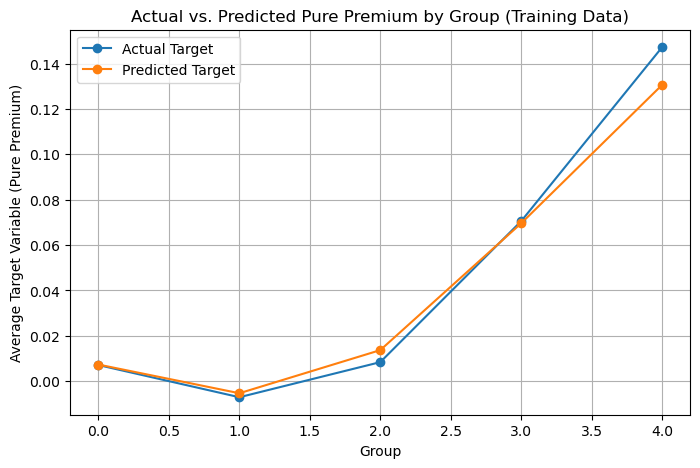

In [28]:
# Step 13: Plot Decile Chart for Training Data

plt.figure(figsize=(8, 5))
plt.plot(rslt_tbl_train['grp'], rslt_tbl_train['act_target'], marker='o', linestyle='-', label='Actual Target')
plt.plot(rslt_tbl_train['grp'], rslt_tbl_train['pred_target'], marker='o', linestyle='-', label='Predicted Target')
plt.xlabel('Group')
plt.ylabel('Average Target Variable (Pure Premium)')
plt.title('Actual vs. Predicted Pure Premium by Group (Training Data)')
plt.legend()
plt.grid(True)
plt.show()


## 14. Make Prediction on the Test Set

In [29]:
# Step 14: Make Predictions on the Test Set

# Reset indices of test data
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
w_test = w_test.reset_index(drop=True)

# Ensure 'prior_loss_ind' is of integer type
rslt_test = pd.DataFrame({
    'act_target': y_test,
    'wt': w_test,
    'pred_target': best_model.predict(X_test),
    'prior_loss_ind': X_test['prior_loss_ind'].astype(int)
})

# Split data into records with no prior claim and records with prior claims
rslta_test = rslt_test.loc[rslt_test['prior_loss_ind'] == 1].copy()  # No prior claims
rsltb_test = rslt_test.loc[rslt_test['prior_loss_ind'] == 0].copy()  # With prior claims

# Sort records with prior claims by predicted target
rsltb_test.sort_values(by='pred_target', ascending=True, inplace=True)

# Create bins/groups for rsltb_test
num_bins = 4  # Adjust as needed

# Calculate cumulative weights
cumulative_weights_test = rsltb_test['wt'].cumsum() / rsltb_test['wt'].sum()

# Cap cumulative weights at 1 to prevent exceeding num_bins
cumulative_weights_test = np.minimum(cumulative_weights_test, 1)

# Assign groups, ensuring group numbers do not exceed num_bins
rsltb_test['grp'] = (cumulative_weights_test * num_bins).apply(np.ceil).astype(int)
rsltb_test['grp'] = rsltb_test['grp'].clip(upper=num_bins)

# Assign group 0 to records with no prior claims
rslta_test['grp'] = 0

# Combine the DataFrames
rslt_combined_test = pd.concat([rslta_test, rsltb_test], ignore_index=True)

# Calculate 'act_loss' and 'pred_loss'
rslt_combined_test['act_loss'] = rslt_combined_test['act_target'] * rslt_combined_test['wt']
rslt_combined_test['pred_loss'] = rslt_combined_test['pred_target'] * rslt_combined_test['wt']

# Aggregate by 'grp'
rslt_tbl_test = rslt_combined_test.groupby('grp').agg({
    'wt': 'sum',
    'act_loss': 'sum',
    'pred_loss': 'sum'
}).reset_index()

# Calculate average targets
rslt_tbl_test['act_target'] = rslt_tbl_test['act_loss'] / rslt_tbl_test['wt']
rslt_tbl_test['pred_target'] = rslt_tbl_test['pred_loss'] / rslt_tbl_test['wt']

print("\nTest Data Decile Summary:")
print(rslt_tbl_test)



Test Data Decile Summary:
   grp          wt     act_loss    pred_loss  act_target  pred_target
0    0  474506.065  1102.578688  3463.952689    0.002324     0.007300
1    1   34700.745  -235.061827  -185.538475   -0.006774    -0.005347
2    2   34701.945   409.534979   483.774843    0.011801     0.013941
3    3   34701.388  2357.407285  2416.830601    0.067934     0.069647
4    4   34701.474  4247.670852  4529.878412    0.122406     0.130539


## 15. Plot Decile Chart for Test Data

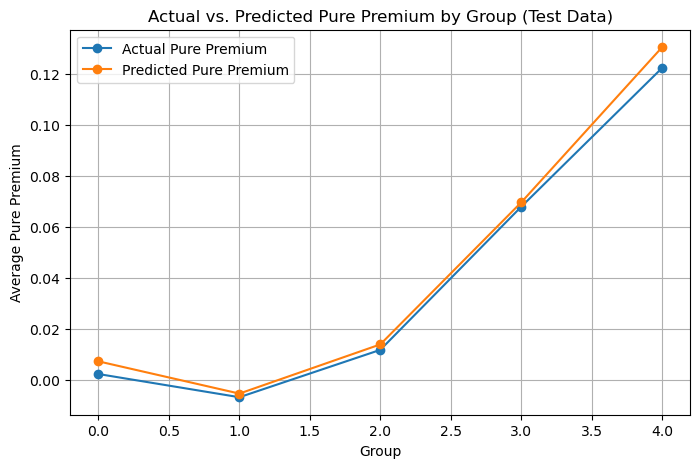

In [30]:
# Step 15: Plot Decile Chart for Test Data with Enhancements

plt.figure(figsize=(8, 5))
plt.plot(rslt_tbl_test['grp'], rslt_tbl_test['act_target'], marker='o', linestyle='-', label='Actual Pure Premium')
plt.plot(rslt_tbl_test['grp'], rslt_tbl_test['pred_target'], marker='o', linestyle='-', label='Predicted Pure Premium')
plt.xlabel('Group')
plt.ylabel('Average Pure Premium')
plt.title('Actual vs. Predicted Pure Premium by Group (Test Data)')
plt.legend()
plt.grid(True)
plt.show()


### Comparing Decile Chart (Train vs. Test)

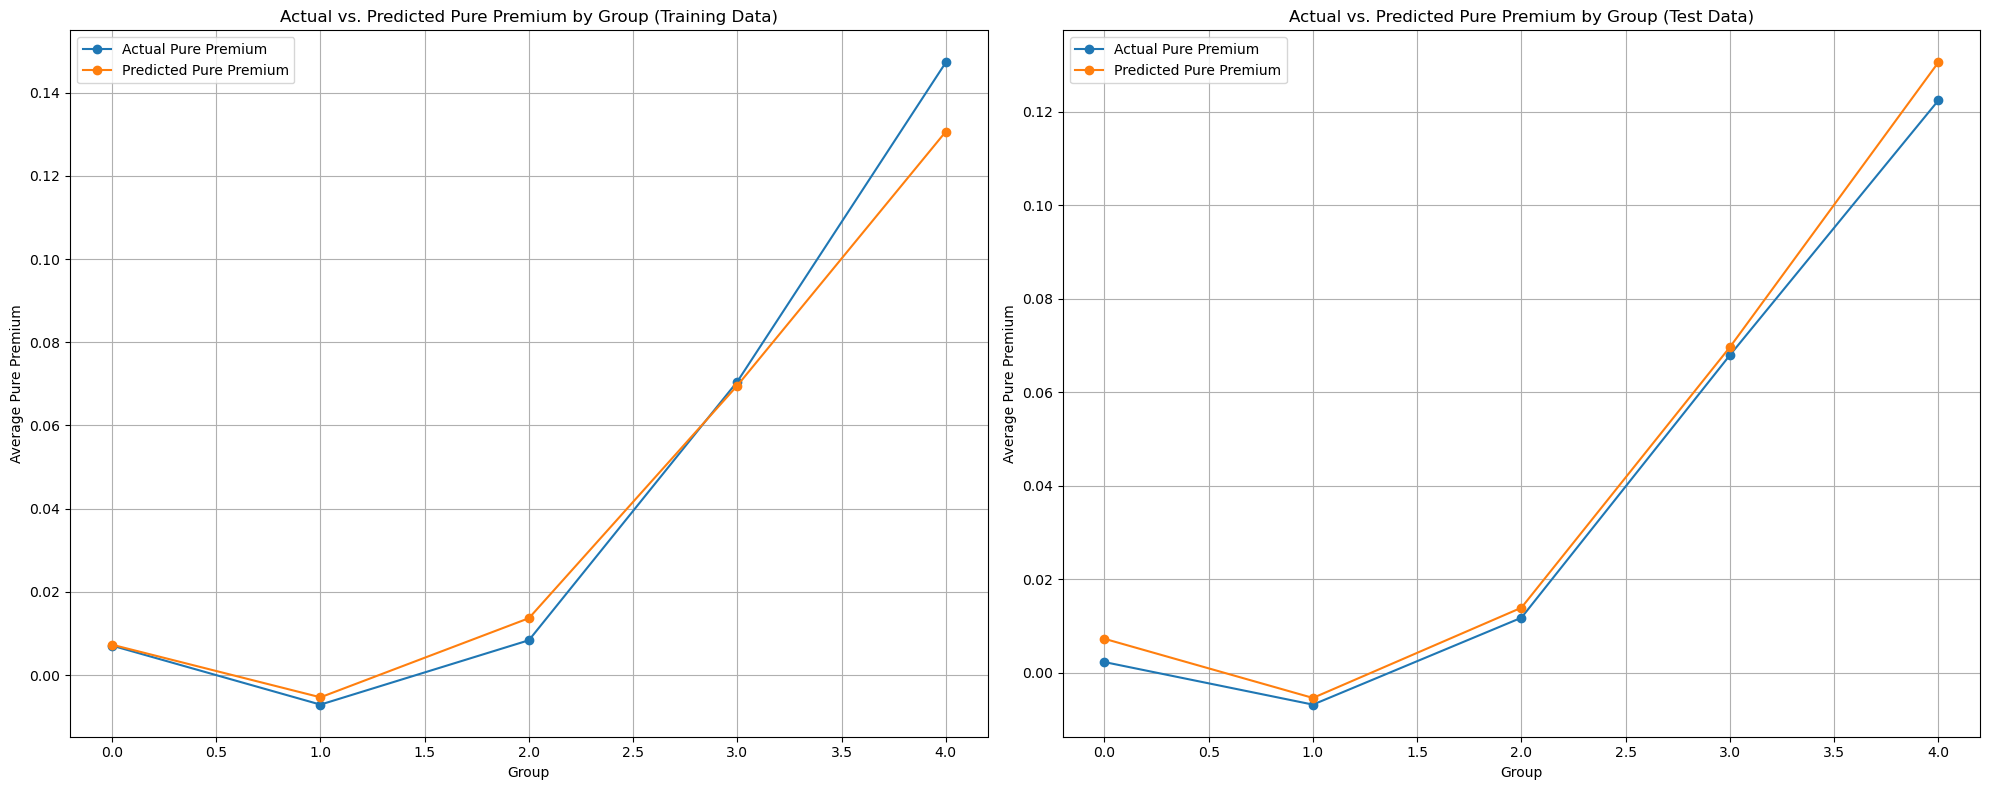

In [31]:
# Comparing Decile Charts for Training and Test Data

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Training Data Decile Chart
axs[0].plot(rslt_tbl_train['grp'], rslt_tbl_train['act_target'], marker='o', linestyle='-', label='Actual Pure Premium')
axs[0].plot(rslt_tbl_train['grp'], rslt_tbl_train['pred_target'], marker='o', linestyle='-', label='Predicted Pure Premium')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('Average Pure Premium')
axs[0].set_title('Actual vs. Predicted Pure Premium by Group (Training Data)')
axs[0].legend()
axs[0].grid(True)

# Test Data Decile Chart
axs[1].plot(rslt_tbl_test['grp'], rslt_tbl_test['act_target'], marker='o', linestyle='-', label='Actual Pure Premium')
axs[1].plot(rslt_tbl_test['grp'], rslt_tbl_test['pred_target'], marker='o', linestyle='-', label='Predicted Pure Premium')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('Average Pure Premium')
axs[1].set_title('Actual vs. Predicted Pure Premium by Group (Test Data)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Residuals Analysis 1

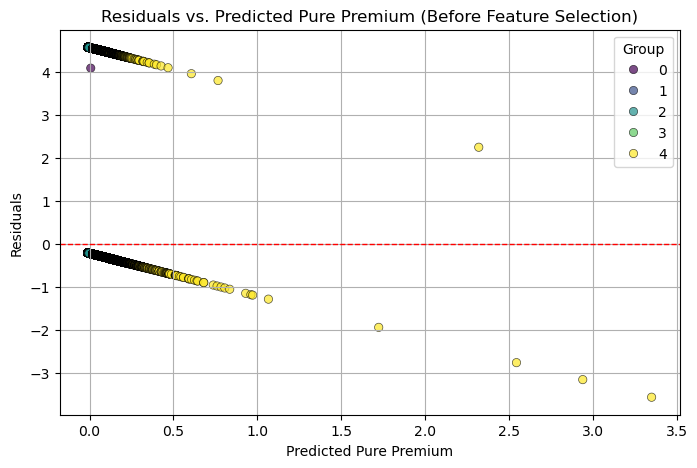

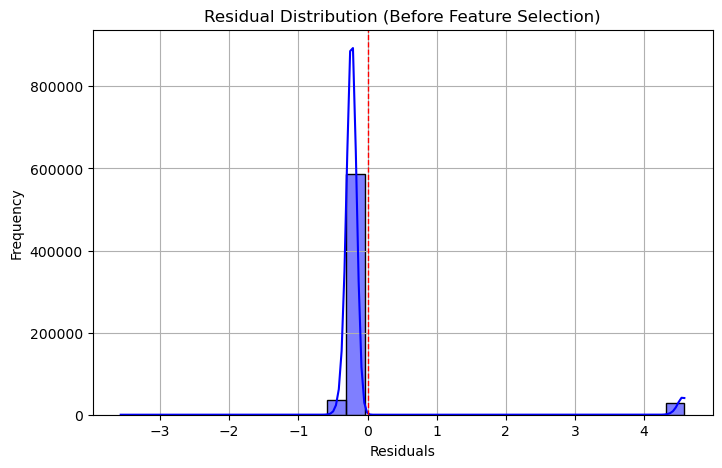


Residual Summary Statistics (Before Feature Selection):
count    653494.000000
mean         -0.019947
std           0.994398
min          -3.569900
25%          -0.225931
50%          -0.225931
75%          -0.225931
max           4.583225
Name: residual, dtype: float64


In [32]:
# Residual Analysis 1 with Enhancements

# Use rslt_combined_test instead of rslt_test
# Calculate residuals (Actual - Predicted)
rslt_combined_test['residual'] = rslt_combined_test['act_target'] - rslt_combined_test['pred_target']

# Plot Residuals vs. Predicted with Enhancements
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=rslt_combined_test['pred_target'],
    y=rslt_combined_test['residual'],
    hue=rslt_combined_test['grp'],
    palette='viridis',
    alpha=0.7,
    edgecolor='k'
)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Pure Premium')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Pure Premium (Before Feature Selection)')
plt.legend(title='Group')
plt.grid(True)
plt.show()

# Plot Residual Distribution
plt.figure(figsize=(8, 5))
sns.histplot(rslt_combined_test['residual'], kde=True, bins=30, color='blue')
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution (Before Feature Selection)')
plt.grid(True)
plt.show()

# Calculate Residual Summary Statistics
residual_stats_before = rslt_combined_test['residual'].describe()
print("\nResidual Summary Statistics (Before Feature Selection):")
print(residual_stats_before)


## 16. Evaluate Model Performance

In [33]:
from sklearn.metrics import mean_absolute_percentage_error


# Step 16: Evaluate Model Performance

# Reverse target transformation if applied
if target_transformer is not None:
    y_test_exp = pd.Series(target_transformer.inverse_transform(y_test.values.reshape(-1, 1)).flatten(), index=y_test.index)
    y_pred_exp = pd.Series(target_transformer.inverse_transform(best_model.predict(X_test).reshape(-1, 1)).flatten(), index=y_test.index)
else:
    y_test_exp = y_test
    y_pred_exp = pd.Series(best_model.predict(X_test), index=y_test.index)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_exp, y_pred_exp, sample_weight=w_test)
rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp, sample_weight=w_test))
r2 = r2_score(y_test_exp, y_pred_exp, sample_weight=w_test)
mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp, sample_weight=w_test) * 100  # Multiply by 100 to get percentage

print("\nModel Evaluation Metrics on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R^2 Score: {r2:.4f}")



Model Evaluation Metrics on Test Set:
Mean Absolute Error (MAE): 645.7977
Root Mean Squared Error (RMSE): 7657.9501
Mean Absolute Percentage Error (MAPE): 8798874313061192.00%
R^2 Score: -0.0072


## 17. Feature Importance and Top Feature Selection

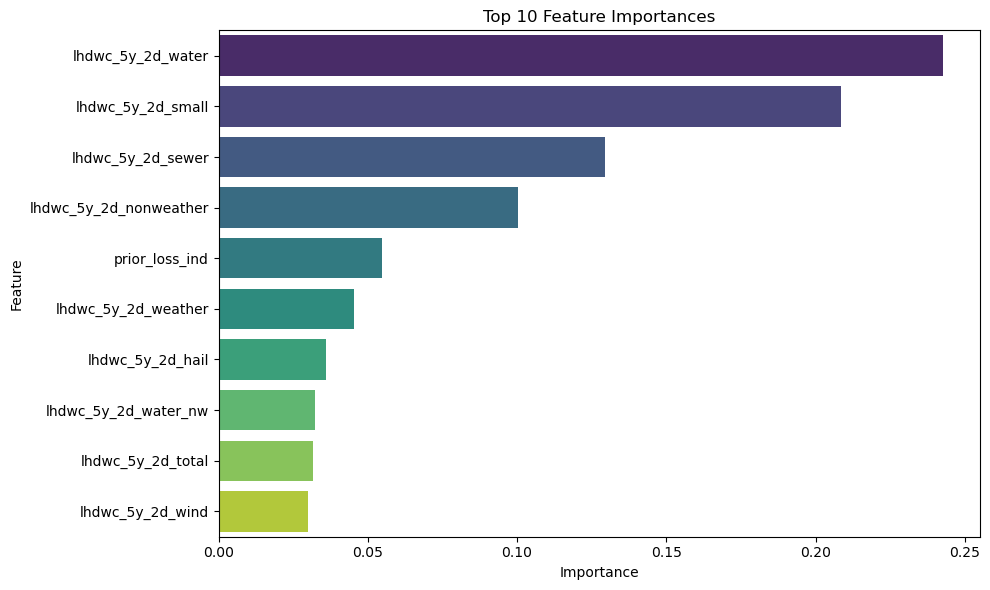


Feature Importances:
                   Feature  Importance
3        lhdwc_5y_2d_water    0.242870
11       lhdwc_5y_2d_small    0.208405
8        lhdwc_5y_2d_sewer    0.129358
10  lhdwc_5y_2d_nonweather    0.100287
14          prior_loss_ind    0.054840
9      lhdwc_5y_2d_weather    0.045513
2         lhdwc_5y_2d_hail    0.035965
4     lhdwc_5y_2d_water_nw    0.032180
13       lhdwc_5y_2d_total    0.031530
1         lhdwc_5y_2d_wind    0.029810
0         lhdwc_5y_2d_fire    0.023820
7        lhdwc_5y_2d_other    0.020801
5      lhdwc_5y_2d_water_w    0.016747
6        lhdwc_5y_2d_theft    0.015369
12       lhdwc_5y_2d_large    0.012505

Top 7 features selected for retraining: ['lhdwc_5y_2d_water', 'lhdwc_5y_2d_small', 'lhdwc_5y_2d_sewer', 'lhdwc_5y_2d_nonweather', 'prior_loss_ind', 'lhdwc_5y_2d_weather', 'lhdwc_5y_2d_hail']


In [34]:
# Step 17: Feature Importance and Top Feature Selection

# Get feature importances from the model
feature_names = X_train_balanced.columns

# Ensure the number of feature names matches the number of importances
if len(feature_names) == len(best_model.feature_importances_):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
else:
    raise ValueError(
        f"Mismatch between feature names ({len(feature_names)}) and "
        f"importance values ({len(best_model.feature_importances_)})"
    )


# Feature Importance Plot

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(10),  # Top 10 features
    palette='viridis'
)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


print("\nFeature Importances:")
print(importance_df)

# Select top 7 features based on importance
top_features = importance_df['Feature'].head(7).tolist()
print("\nTop 7 features selected for retraining:", top_features)


## 18. Retrain Model with Top Features

In [35]:
# Step 18: Retrain Model with Top Features

# Prepare training and test data with top features
if 'prior_loss_ind' not in top_features:
    top_features_with_prior = top_features + ['prior_loss_ind']
else:
    top_features_with_prior = top_features

X_train_top = X_train_balanced[top_features_with_prior]
X_test_top = X_test[top_features_with_prior]

# Create a new monotone constraints dictionary for the top features
# Retrieve original monotone constraints
original_monotone_constraints = best_model.get_params().get('monotone_constraints', {})

# Ensure original_monotone_constraints is a dictionary
if isinstance(original_monotone_constraints, dict):
    monotone_constraints_top = {feature: original_monotone_constraints.get(feature, 0) for feature in top_features_with_prior}
else:
    # If it's a list or tuple, map it to feature names
    feature_names_full = X_train_balanced.columns.tolist()
    if isinstance(original_monotone_constraints, (list, tuple)):
        original_monotone_constraints = dict(zip(feature_names_full, original_monotone_constraints))
        monotone_constraints_top = {feature: original_monotone_constraints.get(feature, 0) for feature in top_features_with_prior}
    else:
        # If it's a string, parse it into a list
        constraints_list = [int(s) for s in original_monotone_constraints.strip('()').split(',')]
        original_monotone_constraints = dict(zip(feature_names_full, constraints_list))
        monotone_constraints_top = {feature: original_monotone_constraints.get(feature, 0) for feature in top_features_with_prior}

# Update params with the new monotone constraints
params = best_model.get_params()
params['monotone_constraints'] = monotone_constraints_top

new_model = XGBRegressor(**params)

# Retrain the model with top features
new_model.fit(
    X_train_top,
    y_train_balanced,
    sample_weight=w_train_balanced
)

print("\nModel retraining with top features completed.")



Model retraining with top features completed.


## 19. Make Predictions with Top Features

In [36]:
# Step 19: Make Predictions with Top Features

# Evaluate the retrained model
y_pred_top = new_model.predict(X_test_top)

# Optional: Reverse target transformation if applied
if target_transformer is not None:
    y_test_exp_top = pd.Series(target_transformer.inverse_transform(y_test.values.reshape(-1, 1)).flatten(), index=y_test.index)
    y_pred_exp_top = pd.Series(target_transformer.inverse_transform(y_pred_top.reshape(-1, 1)).flatten(), index=y_test.index)
else:
    y_test_exp_top = y_test
    y_pred_exp_top = pd.Series(y_pred_top, index=y_test.index)

# Calculate evaluation metrics for the retrained model
mae_top = mean_absolute_error(y_test_exp_top, y_pred_exp_top, sample_weight=w_test)
rmse_top = np.sqrt(mean_squared_error(y_test_exp_top, y_pred_exp_top, sample_weight=w_test))
r2_top = r2_score(y_test_exp_top, y_pred_exp_top, sample_weight=w_test)

## 20. Comparison of Results Before and After Feature Selection

In [37]:
# Step 20: Comparison of Results Before and After Feature Selection

# Calculate evaluation metrics for the retrained model
mae_top = mean_absolute_error(y_test_exp_top, y_pred_exp_top, sample_weight=w_test)
rmse_top = np.sqrt(mean_squared_error(y_test_exp_top, y_pred_exp_top, sample_weight=w_test))
r2_top = r2_score(y_test_exp_top, y_pred_exp_top, sample_weight=w_test)
mape_top = mean_absolute_percentage_error(y_test_exp_top, y_pred_exp_top, sample_weight=w_test) * 100  # Multiply by 100 to get percentage

print("\nComparison of Model Performance Before and After Feature Selection:")
print(f"{'Metric':<40}{'Full Feature Set':>20}{'Top Features':>25}")
print(f"{'Mean Absolute Error (MAE)':<40}{mae:>20.4f}{mae_top:>25.4f}")
print(f"{'Root Mean Squared Error (RMSE)':<40}{rmse:>20.4f}{rmse_top:>25.4f}")
print(f"{'Mean Absolute Percentage Error (MAPE)':<40}{mape:>19.2f}%{mape_top:>24.2f}%")
print(f"{'R^2 Score':<40}{r2:>20.4f}{r2_top:>25.4f}")



Comparison of Model Performance Before and After Feature Selection:
Metric                                      Full Feature Set             Top Features
Mean Absolute Error (MAE)                           645.7977                 645.7977
Root Mean Squared Error (RMSE)                     7657.9501                7657.9501
Mean Absolute Percentage Error (MAPE)   8798874313061192.00%     8790191618680523.00%
R^2 Score                                            -0.0072                  -0.0072


## 21. Plot Decile Chart for Test Data with Top Features

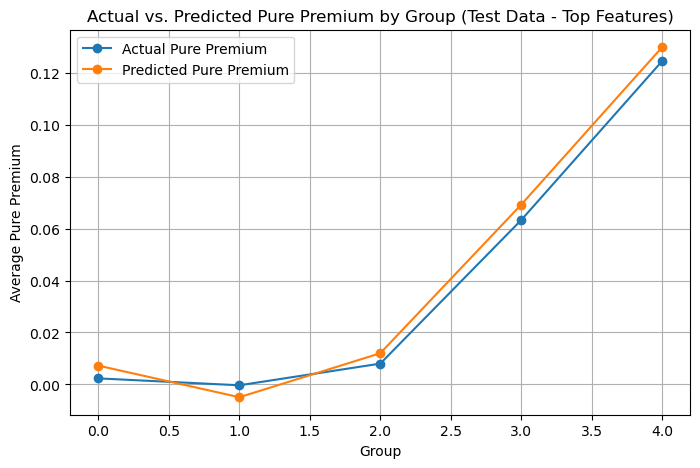

In [38]:
# Step 21: Plot Decile Chart for Test Data with Top Features

# Reset indices of test data
X_test_top = X_test_top.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
w_test = w_test.reset_index(drop=True)

# Ensure 'prior_loss_ind' is of integer type
rslt_test_top = pd.DataFrame({
    'act_target': y_test,
    'wt': w_test,
    'pred_target': new_model.predict(X_test_top),
    'prior_loss_ind': X_test_top['prior_loss_ind'].astype(int)
})

# Split data into records with no prior claim and records with prior claims
rslta_test_top = rslt_test_top.loc[rslt_test_top['prior_loss_ind'] == 1].copy()  # No prior claims
rsltb_test_top = rslt_test_top.loc[rslt_test_top['prior_loss_ind'] == 0].copy()  # With prior claims

# Sort records with prior claims by predicted target
rsltb_test_top.sort_values(by='pred_target', ascending=True, inplace=True)

# Create bins/groups for rsltb_test_top
num_bins = 4  # Adjust as needed

# Calculate cumulative weights
cumulative_weights_test_top = rsltb_test_top['wt'].cumsum() / rsltb_test_top['wt'].sum()

# Cap cumulative weights at 1 to prevent exceeding num_bins
cumulative_weights_test_top = np.minimum(cumulative_weights_test_top, 1)

# Assign groups, ensuring group numbers do not exceed num_bins
rsltb_test_top['grp'] = (cumulative_weights_test_top * num_bins).apply(np.ceil).astype(int)
rsltb_test_top['grp'] = rsltb_test_top['grp'].clip(upper=num_bins)

# Assign group 0 to records with no prior claims
rslta_test_top['grp'] = 0

# Combine the DataFrames
rslt_combined_test_top = pd.concat([rslta_test_top, rsltb_test_top], ignore_index=True)

# Calculate 'act_loss' and 'pred_loss'
rslt_combined_test_top['act_loss'] = rslt_combined_test_top['act_target'] * rslt_combined_test_top['wt']
rslt_combined_test_top['pred_loss'] = rslt_combined_test_top['pred_target'] * rslt_combined_test_top['wt']

# Aggregate by 'grp'
rslt_tbl_test_top = rslt_combined_test_top.groupby('grp').agg({
    'wt': 'sum',
    'act_loss': 'sum',
    'pred_loss': 'sum'
}).reset_index()

# Calculate average targets
rslt_tbl_test_top['act_target'] = rslt_tbl_test_top['act_loss'] / rslt_tbl_test_top['wt']
rslt_tbl_test_top['pred_target'] = rslt_tbl_test_top['pred_loss'] / rslt_tbl_test_top['wt']

# Plot Decile Chart for Test Data with Top Features
plt.figure(figsize=(8, 5))
plt.plot(rslt_tbl_test_top['grp'], rslt_tbl_test_top['act_target'], marker='o', linestyle='-', label='Actual Pure Premium')
plt.plot(rslt_tbl_test_top['grp'], rslt_tbl_test_top['pred_target'], marker='o', linestyle='-', label='Predicted Pure Premium')
plt.xlabel('Group')
plt.ylabel('Average Pure Premium')
plt.title('Actual vs. Predicted Pure Premium by Group (Test Data - Top Features)')
plt.legend()
plt.grid(True)
plt.show()


### Comparing Decile Chart on Test Data (Full Features vs. Top Features)

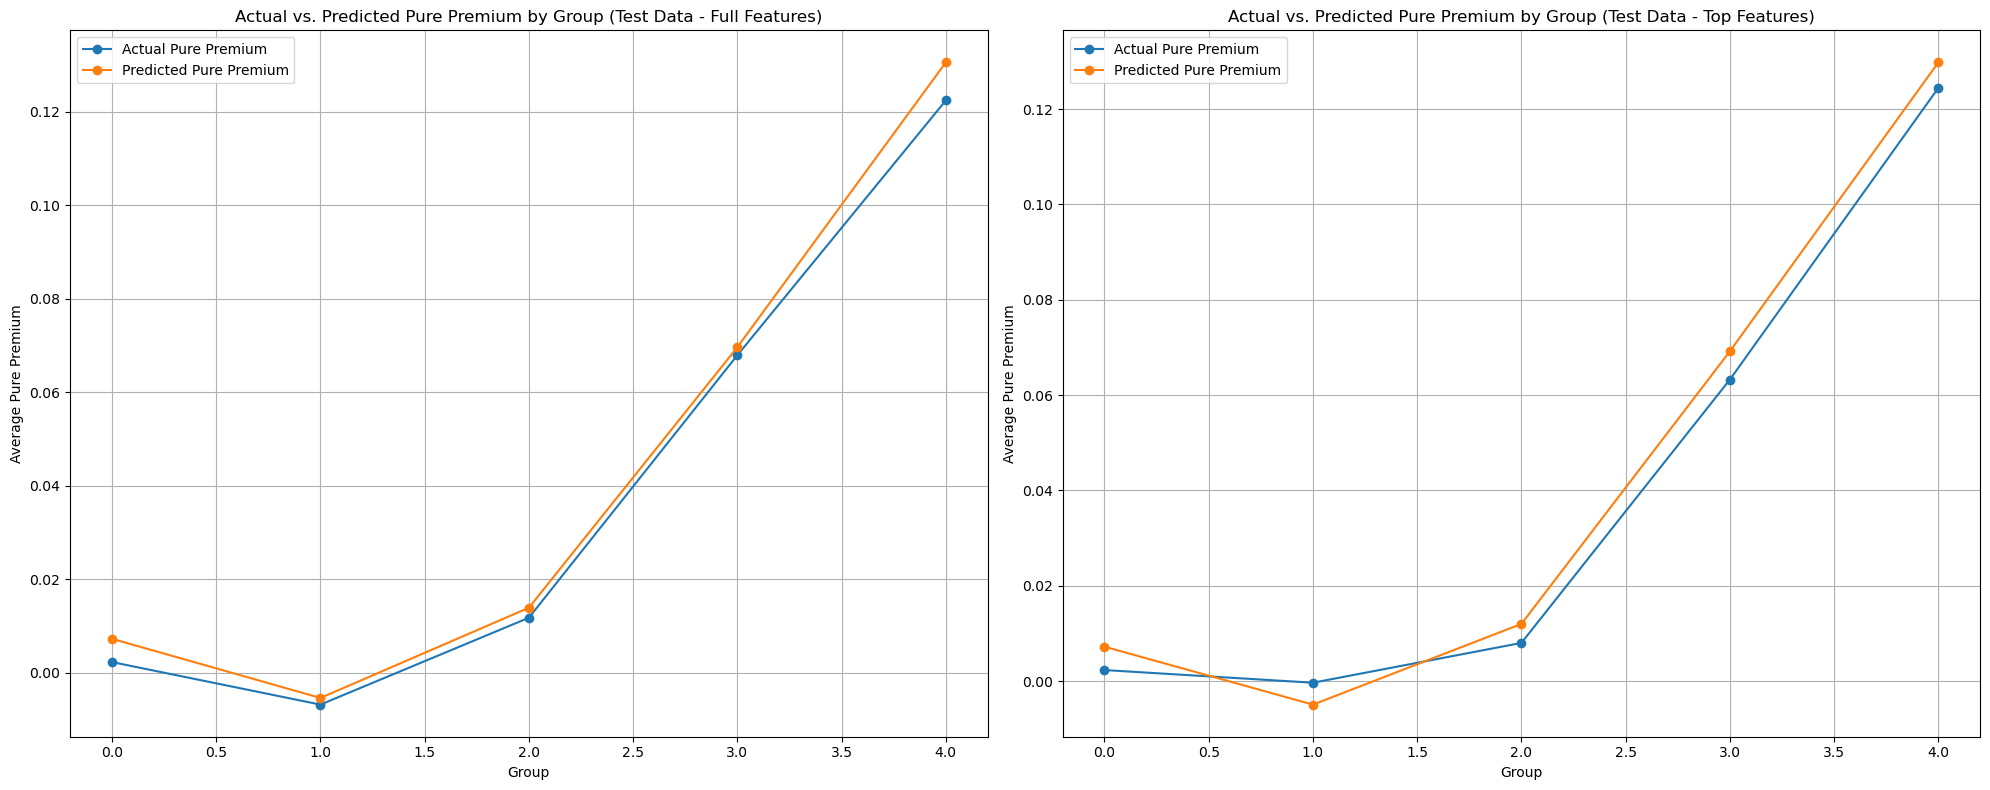

In [39]:

# Comparing Decile Charts Before and After Feature Selection

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Test Data Decile Chart - Full Feature Set
axs[0].plot(rslt_tbl_test['grp'], rslt_tbl_test['act_target'], marker='o', linestyle='-', label='Actual Pure Premium')
axs[0].plot(rslt_tbl_test['grp'], rslt_tbl_test['pred_target'], marker='o', linestyle='-', label='Predicted Pure Premium')
axs[0].set_xlabel('Group')
axs[0].set_ylabel('Average Pure Premium')
axs[0].set_title('Actual vs. Predicted Pure Premium by Group (Test Data - Full Features)')
axs[0].legend()
axs[0].grid(True)

# Test Data Decile Chart - Top Features
axs[1].plot(rslt_tbl_test_top['grp'], rslt_tbl_test_top['act_target'], marker='o', linestyle='-', label='Actual Pure Premium')
axs[1].plot(rslt_tbl_test_top['grp'], rslt_tbl_test_top['pred_target'], marker='o', linestyle='-', label='Predicted Pure Premium')
axs[1].set_xlabel('Group')
axs[1].set_ylabel('Average Pure Premium')
axs[1].set_title('Actual vs. Predicted Pure Premium by Group (Test Data - Top Features)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Residual Analysis 2


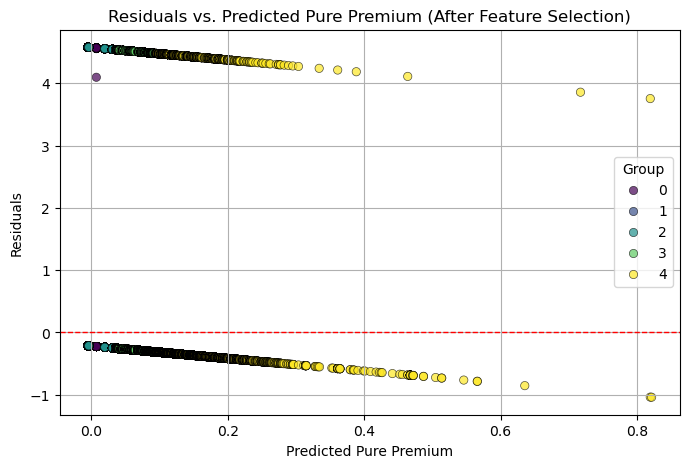

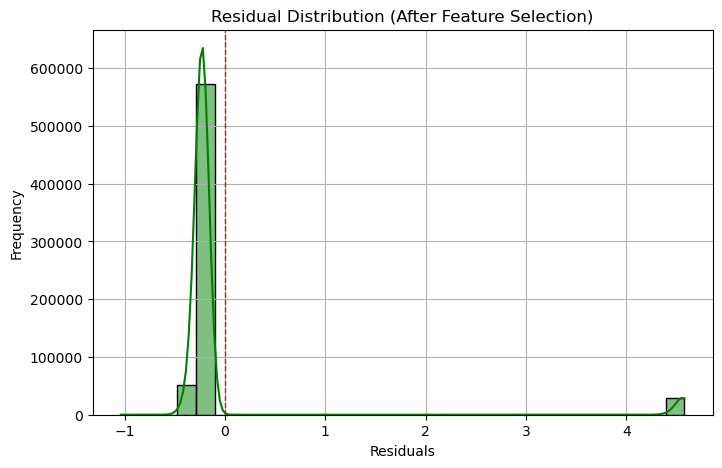


Residual Summary Statistics (After Feature Selection):
count    653494.000000
mean         -0.019728
std           0.994378
min          -1.039964
25%          -0.225854
50%          -0.225854
75%          -0.225854
max           4.578991
Name: residual, dtype: float64


In [40]:
# Residual Analysis 2 with Enhancements

# Ensure 'grp' is in rslt_combined_test_top
if 'grp' not in rslt_combined_test_top.columns:
    print("The 'grp' column is missing in rslt_combined_test_top.")
    # Handle the error or check Step 21

# Calculate residuals (Actual - Predicted)
rslt_combined_test_top['residual'] = rslt_combined_test_top['act_target'] - rslt_combined_test_top['pred_target']

# Plot Residuals vs. Predicted with Enhancements
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=rslt_combined_test_top['pred_target'],
    y=rslt_combined_test_top['residual'],
    hue=rslt_combined_test_top['grp'],
    palette='viridis',
    alpha=0.7,
    edgecolor='k'
)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Pure Premium')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Pure Premium (After Feature Selection)')
plt.legend(title='Group')
plt.grid(True)
plt.show()

# Plot Residual Distribution with Enhancements
plt.figure(figsize=(8, 5))
sns.histplot(rslt_combined_test_top['residual'], kde=True, bins=30, color='green')
plt.axvline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution (After Feature Selection)')
plt.grid(True)
plt.show()

# Calculate Residual Summary Statistics
residual_stats_after = rslt_combined_test_top['residual'].describe()
print("\nResidual Summary Statistics (After Feature Selection):")
print(residual_stats_after)


In [41]:

# 1. Configure MLflow to talk to your EC2 server
mlflow.set_tracking_uri("http://3.146.46.179:5000")

# Optional: Set an experiment name so runs go there (or use default experiment)
mlflow.set_experiment("MyXGBoostExperiment")

# Suppose you have a trained XGBoost model called 'new_model'
# new_model = ...

# 2. Save model locally as 'model.joblib'
joblib.dump(new_model, "Model3.joblib")

# 3. Upload 'model.joblib' to your S3 bucket, e.g. "grange-seniordesign-bucket/models/model.joblib"
s3 = boto3.client("s3")
bucket_name = "grange-seniordesign-bucket"
s3_key = "models/Model3.joblib"  # place it under 'models/' folder
s3.upload_file("Model3.joblib", bucket_name, s3_key)
print(f"Uploaded Model3.joblib to s3://{bucket_name}/{s3_key}")

# 4. Start an MLflow run, log the XGBoost model to your EC2-based MLflow
with mlflow.start_run():
    # Register (or just log) the model in MLflow
    mlflow.xgboost.log_model(
        xgb_model=new_model,
        artifact_path="mlflow-artifacts",
        registered_model_name="HomeownerLossModel_Model_3"  # e.g., add your model number here
    )

    # Optionally log the local .joblib file as an MLflow artifact too (not required, but if you want it in the run artifacts):
    mlflow.log_artifact("Model3.joblib", artifact_path="joblib_files")

print("Successfully logged model to MLflow at http://3.146.46.179:5000")


Uploaded Model3.joblib to s3://grange-seniordesign-bucket/models/Model3.joblib


2025/03/11 21:09:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'HomeownerLossModel_Model_3' already exists. Creating a new version of this model...
2025/03/11 21:09:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: HomeownerLossModel_Model_3, version 2
Created version '2' of model 'HomeownerLossModel_Model_3'.


🏃 View run flawless-grouse-240 at: http://3.146.46.179:5000/#/experiments/10/runs/3b7169b27ef740d18f2b646b2b83be89
🧪 View experiment at: http://3.146.46.179:5000/#/experiments/10
Successfully logged model to MLflow at http://3.146.46.179:5000
